In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 설치해야 할 것들
!pip install h5py
!pip install typing-extensions
!pip install wheel
!pip install xgboost
!pip install catboost
!pip install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 139 kB/s 
     |████████████████████████████████| 320 kB 5.1 MB/s 
     |████████████████████████████████| 636 kB 52.1 MB/s 
     |████████████████████████████████| 88 kB 7.2 MB/s 
     |████████████████████████████████| 1.7 MB 54.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 10.4 MB 4

In [5]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import pandas_profiling
import seaborn as sns
import random as rn
import os
import scipy.stats as stats
import jinja2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from pycaret.utils import enable_colab

from collections import Counter
from pycaret.regression import *

%matplotlib inline
warnings.filterwarnings(action='ignore')

In [6]:
train = pd.read_csv("/content/drive/MyDrive/Travel/data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Travel/data/test.csv")

In [7]:
# 공휴일 확인
holidays = ['09-12', '09-13', '09-14', '10-03', '10-09']
holidays = ['2019-'+day for day in holidays]

train['holiday'] = train.apply(lambda row: 1 if row.date in holidays else 0, axis=1)
test['holiday'] = test.apply(lambda row: 1 if row.date in holidays else 0, axis=1)
train.shape, test.shape

((415423, 22), (228170, 21))

In [8]:
# 날씨 정보 비가오면 1, 그렇지 않으면 0
IsRainy = ['09-04', '09-05', '09-06', '09-07', '09-10', '09-11', '09-12', '09-13', '09-14', '09-22', 
            '10-02', '10-03', '10-05', '10-07']
IsRainy = ['2019-'+ day for day in IsRainy]

train['Rain'] = train.apply(lambda row: 1 if row.date in IsRainy else 0, axis=1)
test['Rain'] = test.apply(lambda row: 1 if row.date in IsRainy else 0, axis=1)

train.shape, test.shape

((415423, 23), (228170, 22))

## 태풍

In [9]:
# 태풍
train['typhoon'] = train['date'].apply(lambda date : 1 if date in ('2019-09-06', '2019-09-07', '2019-09-20', '2019-09-21', '2019-09-22', '2019-10-01','2019-10-02') else 0)
test['typhoon'] = test['date'].apply(lambda date : 1 if date in ('2019-09-06', '2019-09-07', '2019-09-20', '2019-09-21', '2019-09-22', '2019-10-01','2019-10-02') else 0)

In [10]:
# 요일 구분
train['date'] = pd.to_datetime(train['date'])
train['week'] = train['date'].dt.weekday

test['date'] = pd.to_datetime(test['date'])
test['week'] = test['date'].dt.weekday

train.shape, test.shape

((415423, 25), (228170, 24))

In [11]:
# 시내 시외 버스 1과 0으로 각각 변환
train['in_out'] = train['in_out'].map({'시내':0,'시외':1})
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})

In [12]:
#date 변수 변환
train['date2'] = pd.to_datetime(train['date'])
test['date2']=pd.to_datetime(test['date'])
train['week'] = train['date2'].dt.weekday #요일별로 변수 변경(train)

test['date2'] = pd.to_datetime(test['date'])
test['week'] = test['date2'].dt.weekday #요일별로 변수 변경(test)

del train['date2'] #임의 컬럼 삭제
del test['date2']

In [13]:
# Mon-Fri(평일), weekend(주말), holiday(공휴일)
holidays = ['09-12', '09-13', '09-14', '10-03', '10-09']
holidays = ['2019-'+day for day in holidays]

train['holiday'] = train.apply(lambda row: 1 if row.date in holidays else 0, axis=1)
train['weekend'] = train.apply(lambda row: 1 if row.week in [5,6] else 0, axis=1)
train['Mon'] = train.apply(lambda row: 1 if row.week == 0 else 0, axis=1)
train['Tue'] = train.apply(lambda row: 1 if row.week == 1 else 0, axis=1)
train['Wed'] = train.apply(lambda row: 1 if row.week == 2 else 0, axis=1)
train['Thu'] = train.apply(lambda row: 1 if row.week == 3 else 0, axis=1)
train['Fri'] = train.apply(lambda row: 1 if row.week == 4 else 0, axis=1)

test['holiday'] = test.apply(lambda row: 1 if row.date in holidays else 0, axis=1)
test['weekend'] = test.apply(lambda row: 1 if row.week in [5,6] else 0, axis=1)
test['Mon'] = test.apply(lambda row: 1 if row.week == 0 else 0, axis=1)
test['Tue'] = test.apply(lambda row: 1 if row.week == 1 else 0, axis=1)
test['Wed'] = test.apply(lambda row: 1 if row.week == 2 else 0, axis=1)
test['Thu'] = test.apply(lambda row: 1 if row.week == 3 else 0, axis=1)
test['Fri'] = test.apply(lambda row: 1 if row.week == 4 else 0, axis=1)

## 제주시 서귀포시

In [14]:
# 제주시 서귀포시
bus_code= pd.read_csv("/content/drive/MyDrive/Travel/data/bus_code_amend.csv", index_col = 0)

In [15]:
# si_jeju : 제주시면 1, 그렇지 않으면 0
# si_seogwipo : 서귀포시면 1, 그렇지 않으면 0
bus_code=bus_code[['station_code', 'si_jeju', 'si_seogwipo']]
train=pd.merge(train, bus_code, how='left', on='station_code')
test=pd.merge(test, bus_code, how='left', on='station_code')

In [16]:
# 측정소별 거리 측정
jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

In [17]:
import geopy.distance 

In [18]:
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]

train['dis_jeju']=t1
train['dis_gosan']=t2
train['dis_seongsan']=t3
train['dis_po']=t4

total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
train['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

data22=train[['station_name','latitude','longitude','dist_name']].drop_duplicates(keep='first')

Counter(data22['dist_name'])

Counter({0: 1479, 3: 828, 1: 659, 2: 597})

In [19]:
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]

test['dis_jeju']=t1
test['dis_gosan']=t2
test['dis_seongsan']=t3
test['dis_po']=t4

total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
test['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

In [ ]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,holiday,IsRainy,week,weekend,Mon,Tue,Wed,Thu,Fri,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,6,1,0,0,0,0,0,4.286659,37.692766,37.713630,27.841879,0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,6,1,0,0,0,0,0,4.966848,37.008492,38.465822,27.996179,0
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,6,1,0,0,0,0,0,6.330746,35.642126,39.259820,27.496551,0
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0,0,6,1,0,0,0,0,0,3.575272,38.643401,38.386802,29.579404,0
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,6,1,0,0,0,0,0,30.652098,23.648361,45.899140,14.269792,3


# Modeling

In [20]:
# reproducibility 씨드의 배열은 랜덤하지 않게 유지하기 위한 장치
def seed_all(seed_num):
    rn.seed(seed_num)
    os.environ['PYTHONHASHSEED'] = str(seed_num)
    np.random.seed(seed_num)

seed_all(42)

In [21]:
# 테이블에서 필요없는 컬럼들 제거하기(본 자료는 다 예시입니다.)
train_x = train.drop(['id', 'date', 'station_name', 'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff','7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', 'week'], axis = 1)
test_x = test.drop(['id', 'date', 'station_name', 'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff','7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', 'week'], axis = 1)
train_x.head()

,bus_route_id,in_out,station_code,18~20_ride,holiday,Rain,typhoon,weekend,Mon,Tue,Wed,Thu,Fri,si_jeju,si_seogwipo,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name
0,4270000,1,344,0.0,0,0,0,1,0,0,0,0,0,1,0,4.286659,37.692766,37.713630,27.841879,0
1,4270000,1,357,5.0,0,0,0,1,0,0,0,0,0,1,0,4.966848,37.008492,38.465822,27.996179,0
2,4270000,1,432,2.0,0,0,0,1,0,0,0,0,0,1,0,6.330746,35.642126,39.259820,27.496551,0
3,4270000,0,1579,53.0,0,0,0,1,0,0,0,0,0,1,0,3.575272,38.643401,38.386802,29.579404,0
4,4270000,0,1646,0.0,0,0,0,1,0,0,0,0,0,0,1,30.652098,23.648361,45.899140,14.269792,3


In [39]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415423 entries, 0 to 415422
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   bus_route_id  415423 non-null  int64  
 1   in_out        415423 non-null  int64  
 2   station_code  415423 non-null  int64  
 3   18~20_ride    415423 non-null  float64
 4   holiday       415423 non-null  int64  
 5   Rain          415423 non-null  int64  
 6   typhoon       415423 non-null  int64  
 7   weekend       415423 non-null  int64  
 8   Mon           415423 non-null  int64  
 9   Tue           415423 non-null  int64  
 10  Wed           415423 non-null  int64  
 11  Thu           415423 non-null  int64  
 12  Fri           415423 non-null  int64  
 13  si_jeju       415423 non-null  int64  
 14  si_seogwipo   415423 non-null  int64  
 15  dis_jeju      415423 non-null  float64
 16  dis_gosan     415423 non-null  float64
 17  dis_seongsan  415423 non-null  float64
 18  dis_

In [40]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228170 entries, 0 to 228169
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   bus_route_id  228170 non-null  int64  
 1   in_out        228170 non-null  int64  
 2   station_code  228170 non-null  int64  
 3   holiday       228170 non-null  int64  
 4   Rain          228170 non-null  int64  
 5   typhoon       228170 non-null  int64  
 6   weekend       228170 non-null  int64  
 7   Mon           228170 non-null  int64  
 8   Tue           228170 non-null  int64  
 9   Wed           228170 non-null  int64  
 10  Thu           228170 non-null  int64  
 11  Fri           228170 non-null  int64  
 12  si_jeju       228170 non-null  int64  
 13  si_seogwipo   228170 non-null  int64  
 14  dis_jeju      228170 non-null  float64
 15  dis_gosan     228170 non-null  float64
 16  dis_seongsan  228170 non-null  float64
 17  dis_po        228170 non-null  float64
 18  dist

In [22]:
seed_num = 42
py_reg = setup(train_x, target = '18~20_ride', fold_shuffle = True, session_id = seed_num, normalize = True, silent = True, remove_outliers = True)

,Description,Value
0,session_id,42
1,Target,18~20_ride
2,Original Data,"(415423, 20)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,13
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(276256, 20)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='18~20_ride', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_stra...
                 Outlier(contamination=0.05, methods=['pca'], random_state=42,
                         target='18~20_ride')),
                ('cluster_all', 'passthrough'),
                ('dummy', Dummify(tar

In [23]:
py_reg

(None,
 False,
 {'parameter': 'Hyperparameters',
  'residuals': 'Residuals',
  'error': 'Prediction Error',
  'cooks': 'Cooks Distance',
  'rfe': 'Feature Selection',
  'learning': 'Learning Curve',
  'manifold': 'Manifold Learning',
  'vc': 'Validation Curve',
  'feature': 'Feature Importance',
  'feature_all': 'Feature Importance (All)',
  'tree': 'Decision Tree',
  'residuals_interactive': 'Interactive Residuals'},
 {'mae': <pycaret.containers.metrics.regression.MAEMetricContainer at 0x7f94673dc750>,
  'mse': <pycaret.containers.metrics.regression.MSEMetricContainer at 0x7f94673dc6d0>,
  'rmse': <pycaret.containers.metrics.regression.RMSEMetricContainer at 0x7f94673dc690>,
  'r2': <pycaret.containers.metrics.regression.R2MetricContainer at 0x7f94673dc710>,
  'rmsle': <pycaret.containers.metrics.regression.RMSLEMetricContainer at 0x7f94673dc650>,
  'mape': <pycaret.containers.metrics.regression.MAPEMetricContainer at 0x7f94673dc590>},
 Pipeline(memory=None, steps=[('empty_step', 'pas

In [24]:
best = compare_models(sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.8761,7.5879,2.7521,0.6639,0.4693,0.6981,67.744
catboost,CatBoost Regressor,1.1325,8.5907,2.9267,0.6207,0.5670,0.6340,24.605
et,Extra Trees Regressor,0.9489,9.1804,3.0280,0.5929,0.5135,0.7646,47.686
lightgbm,Light Gradient Boosting Machine,1.2318,9.6114,3.0963,0.5758,0.6010,0.5977,1.010
dt,Decision Tree Regressor,0.9616,10.1150,3.1778,0.5518,0.5311,0.8314,1.036
gbr,Gradient Boosting Regressor,1.4570,16.3876,4.0410,0.2800,0.6772,0.6625,21.360
knn,K Neighbors Regressor,1.3463,16.4152,4.0479,0.2747,0.6589,0.7881,2.933
lr,Linear Regression,1.7433,21.8860,4.6716,0.0373,0.7980,0.6738,0.434
ridge,Ridge Regression,1.7431,21.8942,4.6725,0.0369,0.7976,0.6718,0.046
br,Bayesian Ridge,1.7444,21.9125,4.6745,0.0361,0.7980,0.6716,0.181


INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 2
INFO:logs:RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


Y hat : 예측값
Y : 실제값

# 상위 3 모델

In [25]:
# 상위 3개 모델 생성
catboost = create_model('catboost', verbose = False)
rf = create_model('rf', verbose = False)
et = create_model('et', verbose = False)

INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=catboost, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, verbose=False, system=True, metrics=None, experiment_custom_tags=None, add_to_model_list=True, probability_threshold=None, display=None, return_train_score=False, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:CatBoost Regressor Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with KFold(n_splits=10, random_state=42, shuffle=True), n_jobs=-1
INFO:logs:Calculating mean and std
INFO:logs:Creating metrics dataframe
INFO:logs:Finalizing model
INFO:logs:Uploading results into container
INFO:logs:Uploading model into container now
INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:dis

### rf 모델 그래프 결과

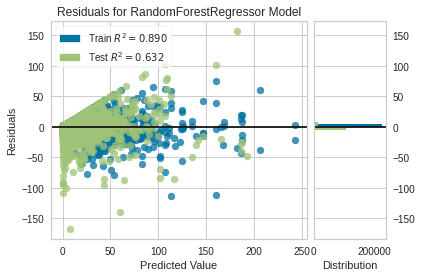

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [26]:
plot_model(rf, plot = 'residuals')

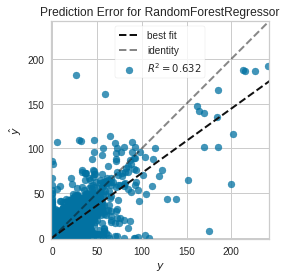

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [27]:
plot_model(rf, plot = 'error')

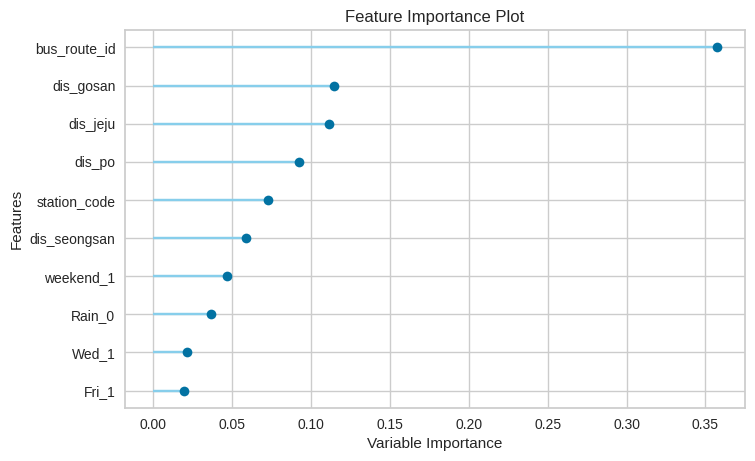

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [28]:
plot_model(rf, plot = 'feature') # top10 feature

In [44]:
prediction_rf = predict_model(rf, data = test_x)
prediction_rf

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,bus_route_id,in_out,station_code,holiday,Rain,typhoon,weekend,Mon,Tue,Wed,Thu,Fri,si_jeju,si_seogwipo,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name,Label
0,4270000,1,344,0,0,1,0,0,1,0,0,0,1,0,4.286659,37.692766,37.713630,27.841879,0,7.876333
1,4270000,1,357,0,0,1,0,0,1,0,0,0,1,0,4.966848,37.008492,38.465822,27.996179,0,15.638167
2,4270000,1,432,0,0,1,0,0,1,0,0,0,1,0,6.330746,35.642126,39.259820,27.496551,0,15.555786
3,4270000,0,1579,0,0,1,0,0,1,0,0,0,1,0,3.575272,38.643401,38.386802,29.579404,0,44.735167
4,4270000,0,1636,0,0,1,0,0,1,0,0,0,0,1,31.460686,23.594010,46.355301,14.445605,3,1.171698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228165,32820000,0,786,0,0,0,0,0,0,1,0,0,1,0,40.193817,1.810388,65.835199,36.362254,1,0.000000
228166,32820000,0,1080,0,0,0,0,0,0,1,0,0,1,0,19.020368,24.608845,51.446906,32.217732,0,0.000000
228167,32820000,0,1129,0,0,0,0,0,0,1,0,0,1,0,27.117280,16.319339,57.465292,33.738981,1,0.000000
228168,32820000,0,1564,0,0,0,0,0,0,1,0,0,1,0,2.134693,39.904297,36.202951,28.484278,0,0.000000


### catboost 모델 그래프 결과

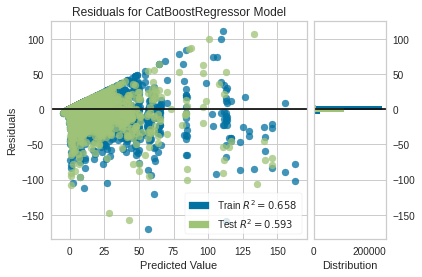

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [29]:
plot_model(catboost, plot = 'residuals')

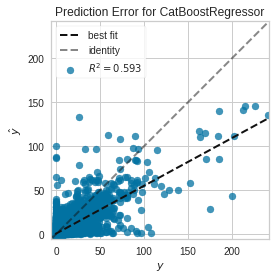

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [30]:
plot_model(catboost, plot = 'error')

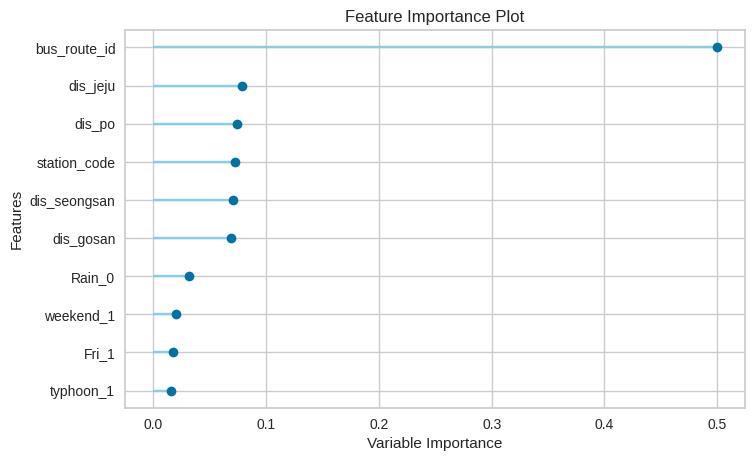

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [38]:
plot_model(et, plot = 'feature') # top10 feature

In [46]:
prediction_cat = predict_model(catboost, data = test_x)
prediction_cat

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=<catboost.core.CatBoostRegressor object at 0x7f946ca38cd0>, probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,bus_route_id,in_out,station_code,holiday,Rain,typhoon,weekend,Mon,Tue,Wed,Thu,Fri,si_jeju,si_seogwipo,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name,Label
0,4270000,1,344,0,0,1,0,0,1,0,0,0,1,0,4.286659,37.692766,37.713630,27.841879,0,12.367118
1,4270000,1,357,0,0,1,0,0,1,0,0,0,1,0,4.966848,37.008492,38.465822,27.996179,0,-0.132943
2,4270000,1,432,0,0,1,0,0,1,0,0,0,1,0,6.330746,35.642126,39.259820,27.496551,0,0.113506
3,4270000,0,1579,0,0,1,0,0,1,0,0,0,1,0,3.575272,38.643401,38.386802,29.579404,0,56.555785
4,4270000,0,1636,0,0,1,0,0,1,0,0,0,0,1,31.460686,23.594010,46.355301,14.445605,3,-0.350292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228165,32820000,0,786,0,0,0,0,0,0,1,0,0,1,0,40.193817,1.810388,65.835199,36.362254,1,-0.015140
228166,32820000,0,1080,0,0,0,0,0,0,1,0,0,1,0,19.020368,24.608845,51.446906,32.217732,0,0.056860
228167,32820000,0,1129,0,0,0,0,0,0,1,0,0,1,0,27.117280,16.319339,57.465292,33.738981,1,1.061676
228168,32820000,0,1564,0,0,0,0,0,0,1,0,0,1,0,2.134693,39.904297,36.202951,28.484278,0,3.733587


### et 모델 그래프 결과

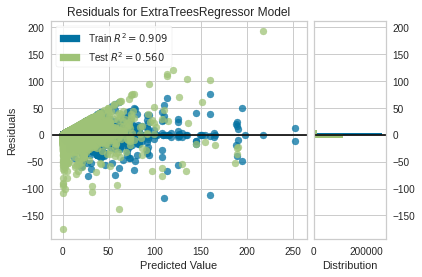

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [31]:
plot_model(et, plot = 'residuals')

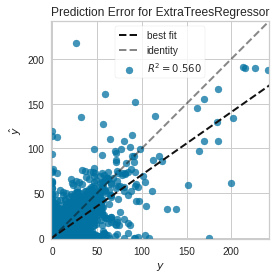

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [32]:
plot_model(et, plot = 'error')

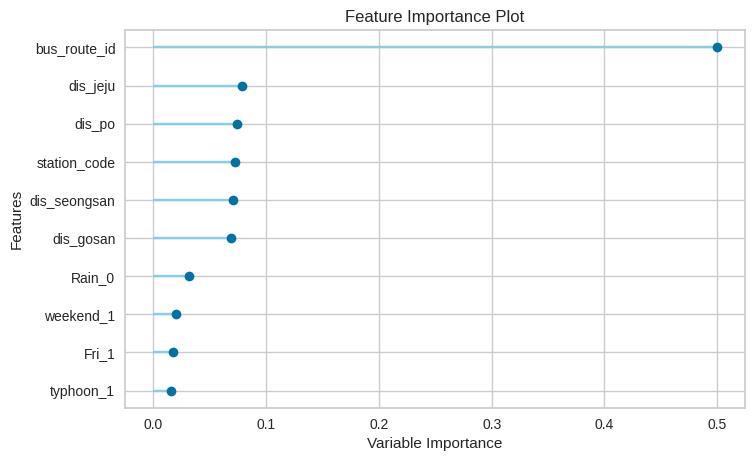

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [33]:
plot_model(et, plot = 'feature') # top10 feature

In [47]:
prediction_et = predict_model(et, data = test_x)
prediction_et

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,bus_route_id,in_out,station_code,holiday,Rain,typhoon,weekend,Mon,Tue,Wed,Thu,Fri,si_jeju,si_seogwipo,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name,Label
0,4270000,1,344,0,0,1,0,0,1,0,0,0,1,0,4.286659,37.692766,37.713630,27.841879,0,16.886667
1,4270000,1,357,0,0,1,0,0,1,0,0,0,1,0,4.966848,37.008492,38.465822,27.996179,0,2.316667
2,4270000,1,432,0,0,1,0,0,1,0,0,0,1,0,6.330746,35.642126,39.259820,27.496551,0,1.315000
3,4270000,0,1579,0,0,1,0,0,1,0,0,0,1,0,3.575272,38.643401,38.386802,29.579404,0,43.230000
4,4270000,0,1636,0,0,1,0,0,1,0,0,0,0,1,31.460686,23.594010,46.355301,14.445605,3,1.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228165,32820000,0,786,0,0,0,0,0,0,1,0,0,1,0,40.193817,1.810388,65.835199,36.362254,1,0.000000
228166,32820000,0,1080,0,0,0,0,0,0,1,0,0,1,0,19.020368,24.608845,51.446906,32.217732,0,0.000000
228167,32820000,0,1129,0,0,0,0,0,0,1,0,0,1,0,27.117280,16.319339,57.465292,33.738981,1,0.000000
228168,32820000,0,1564,0,0,0,0,0,0,1,0,0,1,0,2.134693,39.904297,36.202951,28.484278,0,0.000000


# Blending Models

In [34]:
blend_models = blend_models(estimator_list = [catboost, rf, et])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9057,7.4499,2.7294,0.6961,0.4748,0.6276
1,0.9205,6.1636,2.4827,0.6926,0.4800,0.6518
2,0.9177,6.1845,2.4869,0.7068,0.4819,0.6352
3,0.9256,7.2086,2.6849,0.6500,0.4813,0.6206
4,0.9054,8.1250,2.8504,0.6673,0.4757,0.6345
5,0.9372,6.8796,2.6229,0.6955,0.4812,0.6305
6,0.9305,6.8802,2.6230,0.7058,0.4802,0.6367
7,0.9397,7.5801,2.7532,0.6089,0.4851,0.6279
8,0.9532,7.8068,2.7941,0.7147,0.4794,0.6330


INFO:logs:create_model_container: 23
INFO:logs:master_model_container: 23
INFO:logs:display_container: 6
INFO:logs:VotingRegressor(estimators=[('catboost',
                             <catboost.core.CatBoostRegressor object at 0x7f946cd7e610>),
                            ('rf',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
             

In [35]:
final_model = finalize_model(blend_models)
prediction2 = predict_model(final_model, data = test_x)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=VotingRegressor(estimators=[('catboost',
                             <catboost.core.CatBoostRegressor object at 0x7f946cd7e610>),
                            ('rf',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   mi

In [36]:
prediction2

,bus_route_id,in_out,station_code,holiday,Rain,typhoon,weekend,Mon,Tue,Wed,Thu,Fri,si_jeju,si_seogwipo,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name,Label
0,4270000,1,344,0,0,1,0,0,1,0,0,0,1,0,4.286659,37.692766,37.713630,27.841879,0,0.606776
1,4270000,1,357,0,0,1,0,0,1,0,0,0,1,0,4.966848,37.008492,38.465822,27.996179,0,5.002946
2,4270000,1,432,0,0,1,0,0,1,0,0,0,1,0,6.330746,35.642126,39.259820,27.496551,0,1.663138
3,4270000,0,1579,0,0,1,0,0,1,0,0,0,1,0,3.575272,38.643401,38.386802,29.579404,0,42.906324
4,4270000,0,1636,0,0,1,0,0,1,0,0,0,0,1,31.460686,23.594010,46.355301,14.445605,3,0.861176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228165,32820000,0,786,0,0,0,0,0,0,1,0,0,1,0,40.193817,1.810388,65.835199,36.362254,1,0.071826
228166,32820000,0,1080,0,0,0,0,0,0,1,0,0,1,0,19.020368,24.608845,51.446906,32.217732,0,0.037373
228167,32820000,0,1129,0,0,0,0,0,0,1,0,0,1,0,27.117280,16.319339,57.465292,33.738981,1,0.123950
228168,32820000,0,1564,0,0,0,0,0,0,1,0,0,1,0,2.134693,39.904297,36.202951,28.484278,0,0.953949


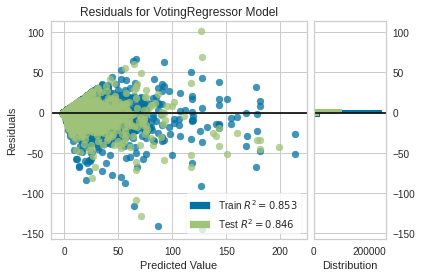

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [37]:
plot_model(final_model, plot = 'residuals')

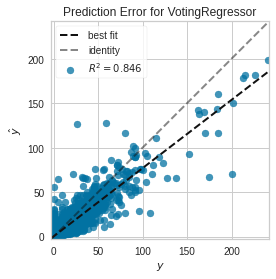

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [41]:
plot_model(final_model, plot = 'error')